# LightGBM Model Tuning

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append("/Users/efim/PycharmProjects/")
sys.path.append("/Users/efim/PycharmProjects/SimpleAlgoTrade/model")
from SimpleAlgoTrade.model import FeatureEngineering as fe
from SimpleAlgoTrade.model.utils import ic_metric
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline, make_union
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_squared_error
from statsmodels.api import OLS, add_constant
import lightgbm as lgb
from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin
from hyperopt.pyll import scope
import hyperopt
import tqdm
from typing import Dict
from plotly import express as px
from plotly import graph_objects as go
from plotly import offline as pyo
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
matplotlib.rcParams['figure.figsize'] = (15, 10)

In [2]:
SEED = 123456789
np.random.seed(SEED)

# Read Data

In [3]:
try:
    os.chdir("../DataBase/files")
except FileNotFoundError:
    pass
!ls -a

.
..
.DS_Store
Archive
price_execution_data_list_16-08-2022-13-24-21.json
price_execution_data_list_16-08-2022-15-32-04.json
trade_book_data_16-08-2022-13-24-21.json
trade_book_data_16-08-2022-15-32-04.json


In [4]:
file_name = "price_execution_data_list"

def read_data_files(name_like: str):
    data_dict = {}
    for file_name in os.listdir():
        if name_like in file_name:
            data_dict[file_name] = pd.read_json(file_name)
    return data_dict

def aggregate_dict_to_dataframe(dictinary):
    df = pd.DataFrame()
    for key, val in dictinary.items():
        df = pd.concat([df, dictinary[key]], axis = 0)
    df.set_index("time", inplace=True)
    return df

price_execution_data = read_data_files(file_name)
price_execution_data_df = aggregate_dict_to_dataframe(price_execution_data)


del price_execution_data

price_execution_data_df = price_execution_data_df.sort_index()

In [5]:
price_execution_data_df.head()

symbol     price  delta_time
time                                       
1.660649e+09  BTCUSDT  24071.72    1.332418
1.660649e+09  BTCUSDT  24071.40    0.611654
1.660649e+09  BTCUSDT  24072.47    1.330175
1.660649e+09  BTCUSDT  24073.85    0.592218
1.660649e+09  BTCUSDT  24072.48    0.634877

# Feature Engineering

In [6]:
feature_shift_return_most_recent = make_pipeline(fe.FeatureSelector('price'), fe.CalcShift(1),fe.CalcReturn())
#feature_shift_return_most_recent

#### Shift Returns

In [7]:
feature_shift_returns = fe.make_union(*(make_pipeline(fe.FeatureSelector('price'), fe.CalcShift(i*13),fe.CalcReturn()) for i in range(1,11)))
# feature_shift_returns

#### MA

In [8]:
feature_ma = fe.make_union(*(make_pipeline(fe.FeatureSelector('price'), fe.CalcMa(i*13), fe.CalcReturn()) for i in range(1,11)))
# feature_ma

#### BB Low

In [9]:
feature_bb_low = fe.make_union(*(make_pipeline(fe.FeatureSelector('price'), fe.CalcBB(13*i,"low"), fe.CalcReturn()) for i in range(1,11)))
# feature_bb_low

#### BB High

In [10]:
feature_bb_high = fe.make_union(*(make_pipeline(fe.FeatureSelector('price'), fe.CalcBB(13*i,"high"), fe.CalcReturn()) for i in range(1,11)))
# feature_bb_high

#### Quantile 0.01

In [11]:
feature_quantile_001 = fe.make_union(*(make_pipeline(fe.FeatureSelector('price'), fe.CalcReturn(), fe.CalcQuantile(13*i,0.01)) for i in range(1,11)))
# feature_quantile_001

#### Quantile 0.99

In [12]:
feature_quantile_099 = fe.make_union(*(make_pipeline(fe.FeatureSelector('price'), fe.CalcReturn(), fe.CalcQuantile(13*i,0.99)) for i in range(1,11)))
# feature_quantile_099

#### Rolling Std

In [13]:
feature_std= fe.make_union(*(make_pipeline(fe.FeatureSelector('price'),fe.CalcReturn(), fe.CalcStd(13*i)) for i in range(1,11)))
# feature_std

#### RSI

In [14]:
feature_rsi = fe.make_union(*(make_pipeline(fe.FeatureSelector('price'),fe.CalcRsi(13*i)) for i in range(1,11)))
# feature_rsi

#### PPO

In [15]:
feature_ppo = make_pipeline(fe.FeatureSelector('price'), fe.CalcPpo())
# feature_ppo

#### Macd

In [16]:
feature_macd = make_pipeline(fe.FeatureSelector('price'), fe.CalcMacd())
# feature_macd

#### Target

In [17]:
target = make_pipeline(fe.FeatureSelector('price'), fe.CalcShift(-13),fe.CalcReturn())
# target

#### Aggregate all Features

In [18]:
feature_union = fe.make_union(feature_shift_return_most_recent,
                              feature_shift_returns,
                              feature_ma,
                              feature_bb_low,
                              feature_bb_high,
                              feature_quantile_001,
                              feature_quantile_099,
                              feature_std,
                              feature_rsi,
                              feature_ppo,
                              feature_macd,
                              target)                           

In [19]:
feature_union

PandasFeatureUnion(transformer_list=[('pipeline-1',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_names='price')),
                                                      ('calcshift',
                                                       CalcShift(shift_val=1)),
                                                      ('calcreturn',
                                                       CalcReturn())])),
                                     ('pandasfeatureunion-1',
                                      PandasFeatureUnion(transformer_list=[('pipeline-1',
                                                                            Pipeline(steps=[('featureselector',
                                                                                             FeatureSelector(feature_names='price')),
                                                                                            ('calc...
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_names='price')),
                                                      ('calcppo', CalcPpo())])),
                                     ('pipeline-3',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_names='price')),
                                                      ('calcmacd',
                                                       CalcMacd())])),
                                     ('pipeline-4',
                                      Pipeline(steps=[('featureselector',
                                                       FeatureSelector(feature_names='price')),
                                                      ('calcshift',
                                                       CalcShift(shift_val=-13)),
                                                      ('calcreturn',
                                                       CalcReturn())]))])

## Create Train-Test Data

In [20]:
data = feature_union.fit_transform(price_execution_data_df)

In [21]:
data = data.dropna()
train_size = 0.8
test_size = 1-train_size
data_size = data.shape[0]

data_train = data.iloc[:int(data_size*train_size)]
data_test = data.iloc[int(data_size*train_size):]

target_names = ["returns_forward_13"]
feature_names = data.columns[:-1]

X_train, y_train = data_train[feature_names], data_train[target_names]
X_test, y_test = data_test[feature_names], data_test[target_names]

In [22]:
X_train.shape

(15895, 83)

In [23]:
X_test.shape

(3974, 83)

## Hyper Parameter Tuning

In [24]:
# Time Series Cross Validation
def time_series_cross_validation(X: pd.DataFrame,
                                 y: pd.DataFrame,
                                 init_train_size:int,
                                 val_cv:int,
                                 model: callable,
                                 params: Dict):
    """
    X - feature data
    y - target data
    init_train_size - initial train data size
    cv - cross validation size
    """
    scores = {"train_ic":[],
              "val_ic":[],
              "sample_size":[],
              "train_rmse": [],
              "val_rmse": []}
    regressor = model(**params)
    for sample_size in range(init_train_size, X.shape[0], val_cv):
        X_train = X.iloc[:sample_size]
        y_train = y.iloc[:sample_size]
        X_val = X.iloc[sample_size:sample_size+val_cv]
        y_val = y.iloc[sample_size:sample_size+val_cv]
        regressor.fit(X_train,y_train)
        y_train_pred = regressor.predict(X_train)
        y_val_pred = regressor.predict(X_val)
        scores["train_ic"].append(ic_metric(y_train, y_train_pred))
        scores["val_ic"].append(ic_metric(y_val, y_val_pred))
        scores["train_rmse"].append(mean_squared_error(y_train,y_train_pred))
        scores["val_rmse"].append(mean_squared_error(y_val, y_val_pred))
        scores["sample_size"].append(sample_size)
        sample_size += val_cv
    return scores 

# Setup objective function
def objective(params):
    cv_config = params["cv_config"]
    X, y , init_train_size, val_cv, model = cv_config.get("X"), cv_config.get("y"), cv_config.get("init_train_size"), cv_config.get("val_cv"), cv_config.get("model")
    scores = time_series_cross_validation(X,
                                          y,
                                          init_train_size,
                                          val_cv,
                                          model,
                                          params["space"])  
    return -np.mean(scores["val_ic"])

In [25]:
# CV Config
cv_config = {"X": X_train,
            "y": y_train,
            "init_train_size": 10000,
            "val_cv": 250,
            "model": lgb.LGBMRegressor}

# Uninformative Priors
space = {
    'learning_rate':    hp.uniform('learning_rate', 0.01, 2),
    'num_leaves':       scope.int(hp.uniform('num_leaves', 2, 20)),
    'max_depth':        scope.int(hp.uniform('max_depth', 1, 20)),
    'subsample':        hp.uniform('subsample', 0.6, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1), #feature_fraction
    'num_iterations':   scope.int(hp.uniform('num_iterations',5, 400)),
    # 'reg_alpha':        hp.choice("reg_alpha", np.arange(0, 2, 0.1)), #L1 can shirnk most of the features to zero, which will produce straight line pred
    'reg_lambda':        hp.uniform("reg_lambda",0, 5), #L2
    'seed': SEED
        }

params = {"cv_config":cv_config,
          "space": space}

trials = Trials()
best = fmin(fn=objective,
            space=params,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials,
            rstate=np.random.default_rng(SEED))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [25:11<00:00,  7.56s/trial, best loss: -0.03382063418707294]


In [26]:
best

{'colsample_bytree': 0.9073245190249477,
 'learning_rate': 0.8362765112862323,
 'max_depth': 5.795458069323013,
 'num_iterations': 154.30736269988873,
 'num_leaves': 11.409479385608066,
 'reg_lambda': 2.8689492539762513,
 'subsample': 0.8105926533316665}

#### Tuning Result Visualisation

In [27]:
def unpack(x):
    if x:
        return x[0]
    return np.nan

trials_df = pd.DataFrame([pd.Series(t["misc"]["vals"]).apply(unpack) for t in trials])
trials_df["loss"] = [t["result"]["loss"] for t in trials]
trials_df["trial_number"] = trials_df.index

int_col_names = ["max_depth", "num_iterations","num_leaves"]
for col_name in int_col_names:
    trials_df[col_name] = trials_df[col_name].apply(lambda x: round(x))
trials_df["corr"] = trials_df["loss"].apply(lambda x: -x) # the hyperopt goal is to minimize -corr

In [28]:
trials_df.sort_values(by="corr", ascending=False)

colsample_bytree  learning_rate  max_depth  num_iterations  num_leaves  \
2            0.907325       0.836277          6             154          11   
56           0.827558       0.884786          7             344          16   
113          0.897715       0.827892         15             175          19   
89           0.732165       0.549636         19             268          14   
130          0.915108       1.372797         17             161          18   
..                ...            ...        ...             ...         ...   
97           0.735706       0.790689          7             311          20   
84           0.918148       0.825265          9             190           8   
39           0.818831       1.259677         17              49          14   
181          0.905013       0.761663         12             262          11   
45           0.600650       1.055966         18             118           7   

     reg_lambda  subsample      loss  trial_number      corr  
2      2.868949   0.810593 -0.033821             2  0.033821  
56     2.498218   0.905005 -0.031934            56  0.031934  
113    3.895779   0.995305 -0.026505           113  0.026505  
89     0.883844   0.744865 -0.026131            89  0.026131  
130    3.946307   0.905825 -0.024781           130  0.024781  
..          ...        ...       ...           ...       ...  
97     0.945508   0.745887  0.018917            97 -0.018917  
84     2.731223   0.883281  0.021312            84 -0.021312  
39     3.664916   0.812888  0.021504            39 -0.021504  
181    3.727888   0.815731  0.026336           181 -0.026336  
45     2.182601   0.656977  0.033866            45 -0.033866  

[200 rows x 10 columns]

In [29]:
# Save trials data
path = "/Users/efim/PycharmProjects/SimpleAlgoTrade/model/data/"
trials_df.to_csv(path+"light_gbm_trials.csv")

#### Trials vs Objective Func

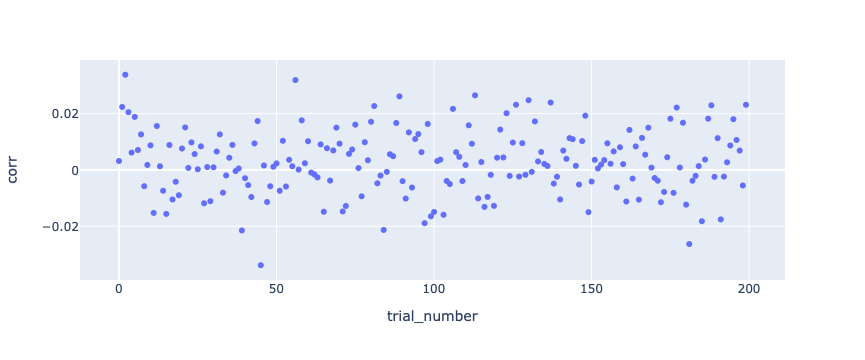

In [30]:
px.scatter(trials_df, x="trial_number", y="corr")

#### Contour plot
Feature vs Objective Func

Num Leaves vs Num Iteration

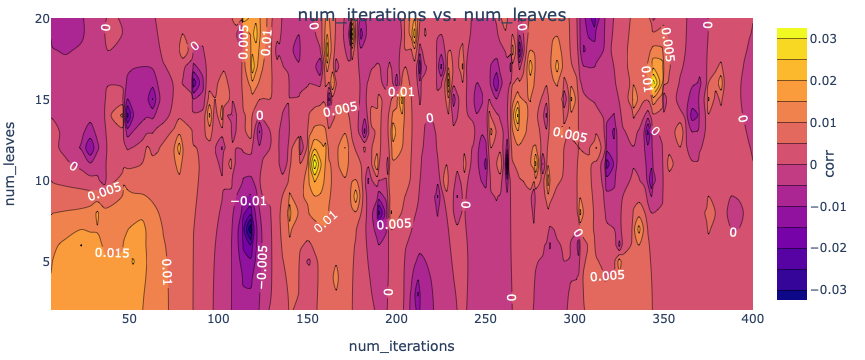

In [31]:
fig = go.Figure(
    data=go.Contour(
        z=trials_df["corr"],
        x=trials_df["num_iterations"],
        y=trials_df["num_leaves"],
        contours=dict(
            showlabels=True,  # show labels on contours
            labelfont=dict(size=12, color="white",),  # label font properties
        ),
        colorbar=dict(title="corr", titleside="right",),
        hovertemplate="corr: %{z}<br>num_iterations: %{x}<br>num_leaves: %{y}<extra></extra>",
    )
)

fig.update_layout(
    xaxis_title="num_iterations",
    yaxis_title="num_leaves",
    title={
        "text": "num_iterations vs. num_leaves",
        "xanchor": "center",
        "yanchor": "top",
        "x": 0.5,
    },
    margin=dict(l=10, r=10, t=10, b=10)
)

learning_rate vs num_iterations

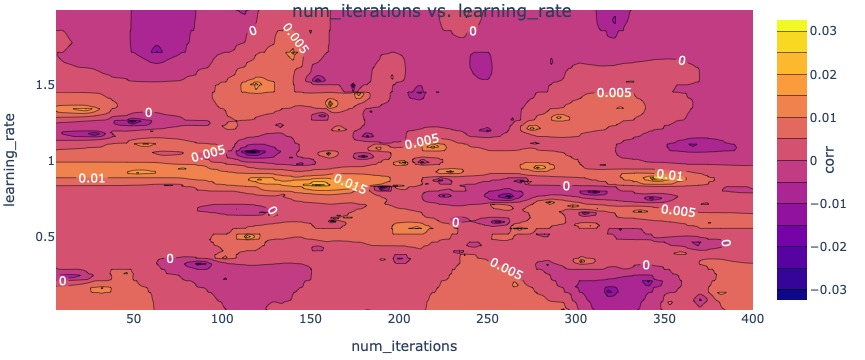

In [32]:
fig = go.Figure(
    data=go.Contour(
        z=trials_df["corr"],
        x=trials_df["num_iterations"],
        y=trials_df["learning_rate"],
        contours=dict(
            showlabels=True,  # show labels on contours
            labelfont=dict(size=12, color="white",),  # label font properties
        ),
        colorbar=dict(title="corr", titleside="right",),
        hovertemplate="corr: %{z}<br>num_iterations: %{x}<br>learning_rate: %{y}<extra></extra>",
    )
)

fig.update_layout(
    xaxis_title="num_iterations",
    yaxis_title="learning_rate",
    title={
        "text": "num_iterations vs. learning_rate",
        "xanchor": "center",
        "yanchor": "top",
        "x": 0.5,
    },
    margin=dict(l=10, r=10, t=10, b=10)
)

## Re-Train the Model with best Params

In [33]:
def map_to_int(params):
    params_mapped = {}
    for key, val in params.items():
        if key in int_col_names:
            params_mapped[key] = round(val)
        else:
            params_mapped[key] = val
    return params_mapped
        
best_params = map_to_int(best)
print(best_params)

{'colsample_bytree': 0.9073245190249477, 'learning_rate': 0.8362765112862323, 'max_depth': 6, 'num_iterations': 154, 'num_leaves': 11, 'reg_lambda': 2.8689492539762513, 'subsample': 0.8105926533316665}


In [34]:
scores =  time_series_cross_validation(X_train,
                                       y_train,
                                       cv_config["init_train_size"],
                                       cv_config["val_cv"],
                                       cv_config["model"],
                                       best_params)

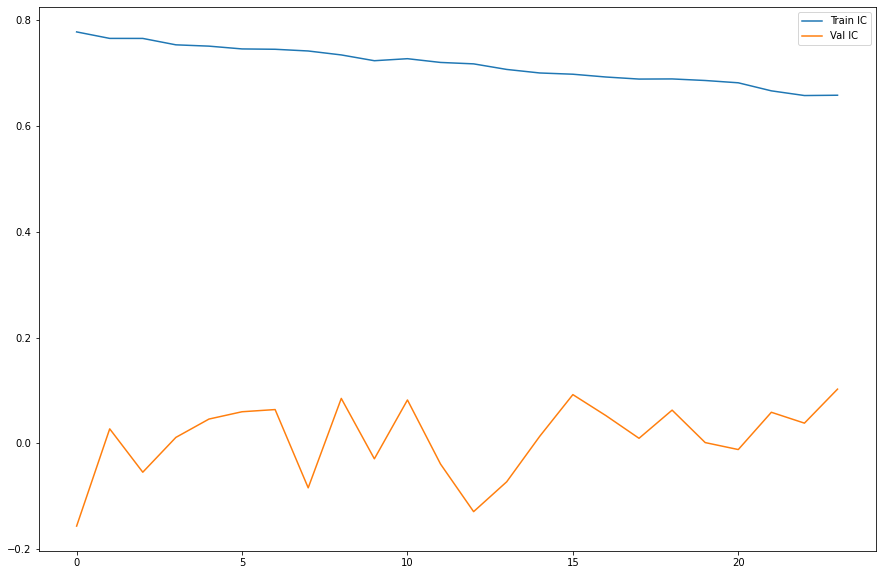

In [35]:
plt.plot(scores["train_ic"], label="Train IC")
plt.plot(scores["val_ic"], label="Val IC")
plt.legend()

In [36]:
np.mean(scores["val_ic"])

0.009715709631665424

In [37]:
model = lgb.LGBMRegressor(**best_params)
model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.9073245190249477,
              learning_rate=0.8362765112862323, max_depth=6, num_iterations=154,
              num_leaves=11, reg_lambda=2.8689492539762513,
              subsample=0.8105926533316665)

Text(0.5, 1.0, 'Top 50 feature imporance')

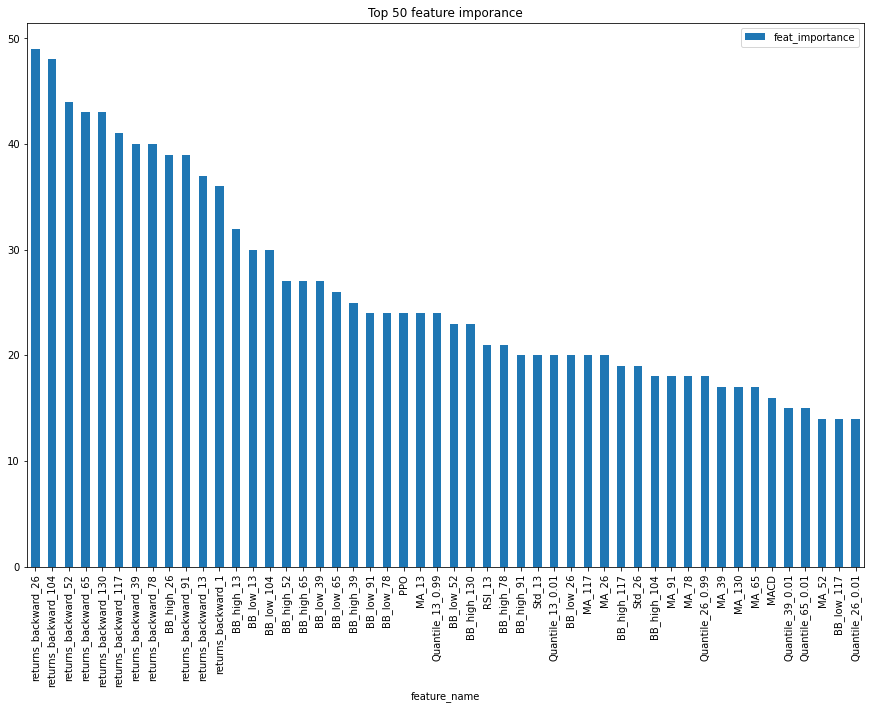

In [38]:
top = 50
df_feat = (
    pd.DataFrame({"feat_importance": model.feature_importances_,
                  "feature_name": X_train.columns})
    .sort_values(by="feat_importance", ascending=False)
          )
df_feat.head(top).plot.bar(x="feature_name", y ="feat_importance")
plt.title(f"Top {top} feature imporance")

## Hyper Parameter Significance

In [39]:
ols = OLS(endog=trials_df['corr'], exog=add_constant(trials_df.drop(['loss','trial_number','corr'], axis=1))).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   corr   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9958
Date:                Mon, 12 Sep 2022   Prob (F-statistic):              0.436
Time:                        19:44:31   Log-Likelihood:                 614.79
No. Observations:                 200   AIC:                            -1214.
Df Residuals:                     192   BIC:                            -1187.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0058      0.010  

In [40]:
pd.concat([ols.params.to_frame('coef'),
           ols.conf_int().rename({0:"lower",1:"upper"},axis=1),
          ], axis=1)

coef     lower     upper
const            -5.836210e-03 -0.025442  0.013769
colsample_bytree -3.397500e-03 -0.021258  0.014463
learning_rate    -2.203208e-03 -0.006004  0.001597
max_depth         7.705036e-05 -0.000237  0.000391
num_iterations   -8.520231e-07 -0.000018  0.000017
num_leaves       -1.499486e-04 -0.000529  0.000229
reg_lambda        9.867244e-04 -0.000339  0.002312
subsample         1.469667e-02 -0.002225  0.031618

## Model Interperation Partial Depedency
Note: Correlation in between features are ignored

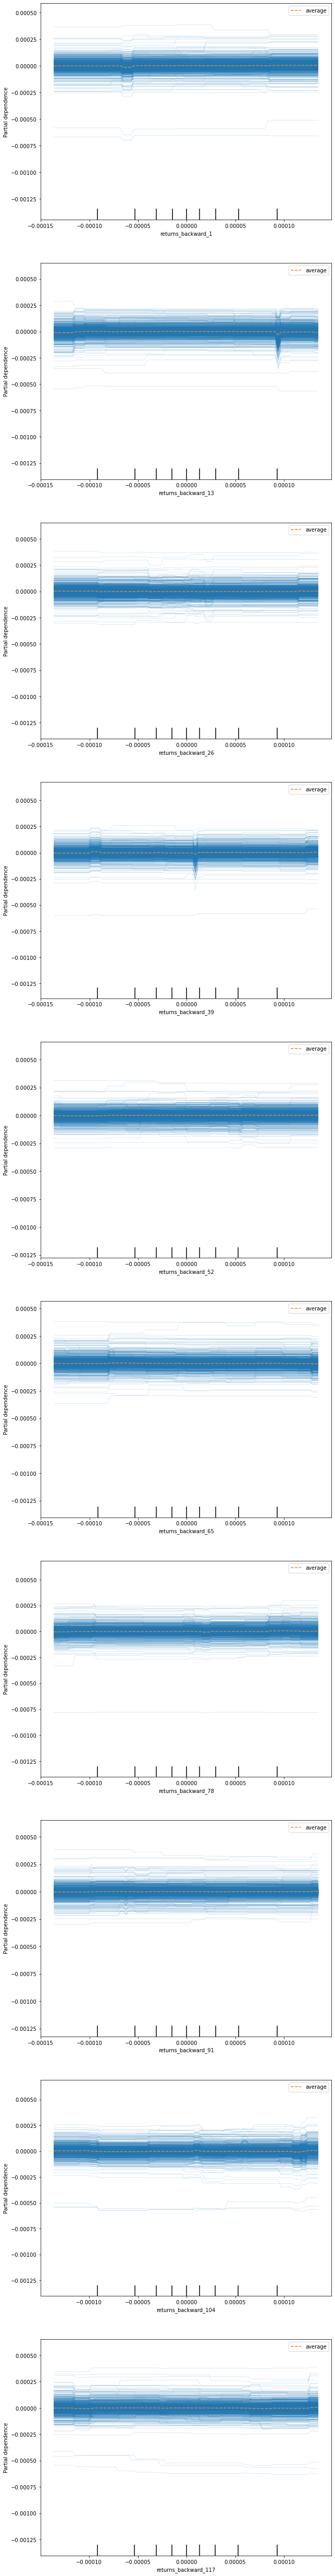

In [41]:
num_feat = 10
fig, ax = plt.subplots(10,1, figsize=(10, 90))
for i in range(num_feat):
    feat = df_feat["feature_name"][i]
    PartialDependenceDisplay.from_estimator(model, X_train, [feat], kind='both', ax=ax[i])

#### Model Prediction Returns

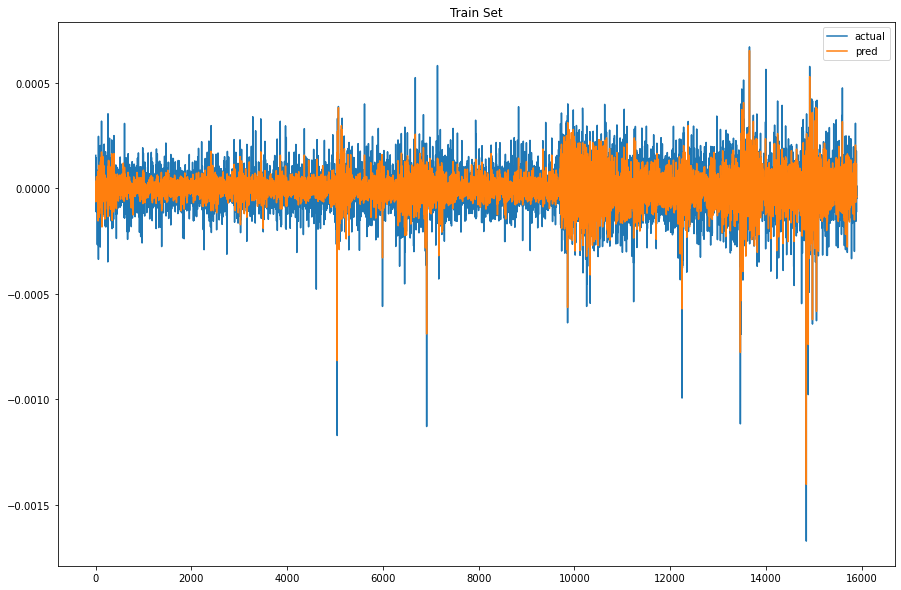

In [42]:
plt.plot(y_train.values, label = "actual")
plt.plot(model.predict(X_train), label ="pred")
plt.title("Train Set")
plt.legend()

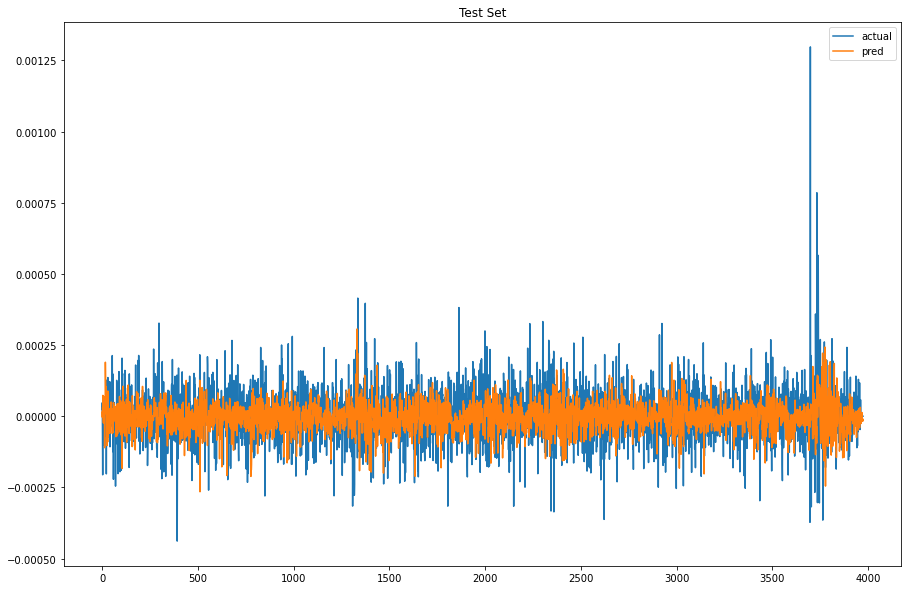

In [43]:
plt.plot(y_test.values, label = "actual")
plt.plot(model.predict(X_test), label ="pred")
plt.title("Test Set")
plt.legend()

#### Model Prediction Prices

#### In-Sample Data

In [44]:
y_train_pred = pd.Series(model.predict(X_train), index = X_train.index, name="train_return_pred_13")
price_execution_data_df["price_shift_13"] = price_execution_data_df["price"].shift(-13)
price_execution_data_df["price_pct_change_13"] = price_execution_data_df["price"].shift(-13).pct_change()
price_execution_data_df["multiplicator"] = price_execution_data_df["price_shift_13"].shift(1)
full_data_train = price_execution_data_df.merge(y_train, left_index=True, right_index=True)
full_data_train = full_data_train.merge(y_train_pred, left_index=True, right_index=True)
full_data_train.head(10)

symbol     price  delta_time  price_shift_13  \
time                                                          
1.660649e+09  BTCUSDT  24078.99    0.613602        24078.93   
1.660649e+09  BTCUSDT  24080.96    0.613479        24077.98   
1.660649e+09  BTCUSDT  24079.51    1.428748        24078.31   
1.660649e+09  BTCUSDT  24078.57    0.614810        24078.82   
1.660649e+09  BTCUSDT  24079.09    0.613618        24078.31   
1.660649e+09  BTCUSDT  24079.84    0.613721        24078.74   
1.660649e+09  BTCUSDT  24078.14    0.613349        24076.06   
1.660649e+09  BTCUSDT  24078.53    1.432766        24074.90   
1.660649e+09  BTCUSDT  24075.34    1.334504        24078.35   
1.660649e+09  BTCUSDT  24073.91    0.612562        24078.91   

              price_pct_change_13  multiplicator  returns_forward_13  \
time                                                                   
1.660649e+09             0.000155       24075.19            0.000155   
1.660649e+09            -0.000039       24078.93           -0.000039   
1.660649e+09             0.000014       24077.98            0.000014   
1.660649e+09             0.000021       24078.31            0.000021   
1.660649e+09            -0.000021       24078.82           -0.000021   
1.660649e+09             0.000018       24078.31            0.000018   
1.660649e+09            -0.000111       24078.74           -0.000111   
1.660649e+09            -0.000048       24076.06           -0.000048   
1.660649e+09             0.000143       24074.90            0.000143   
1.660649e+09             0.000023       24078.35            0.000023   

              train_return_pred_13  
time                                
1.660649e+09              0.000026  
1.660649e+09             -0.000017  
1.660649e+09             -0.000016  
1.660649e+09             -0.000064  
1.660649e+09             -0.000039  
1.660649e+09              0.000016  
1.660649e+09             -0.000043  
1.660649e+09             -0.000018  
1.660649e+09              0.000011  
1.660649e+09             -0.000031

In [45]:
full_data_train.shape

(15895, 8)

In [46]:
assert ((full_data_train["multiplicator"]*(1+full_data_train["returns_forward_13"]) - full_data_train["price_shift_13"]) < 1e-6).all(), "Oops Prices are not alligned"

In [47]:
full_data_train["train_price_pred_13"]  = full_data_train["multiplicator"]*(1+full_data_train["train_return_pred_13"])

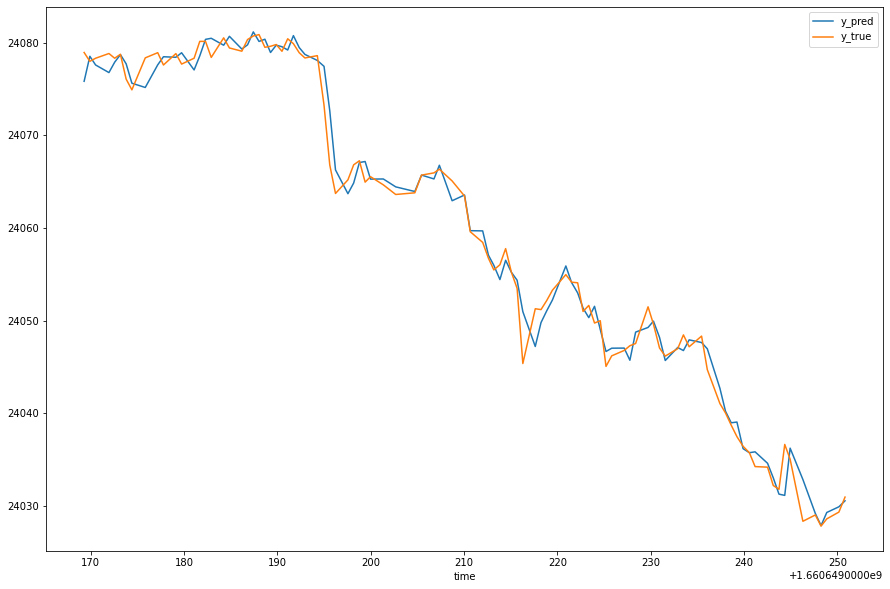

In [48]:
full_data_train["train_price_pred_13"].iloc[:100].plot(label="y_pred")
full_data_train["price_shift_13"].iloc[:100].plot(label="y_true")
plt.legend()

#### Out-Sample Data

In [49]:
y_test_pred = pd.Series(model.predict(X_test), index = X_test.index, name="test_return_pred_13")
price_execution_data_df["price_shift_13"] = price_execution_data_df["price"].shift(-13)
price_execution_data_df["price_pct_change_13"] = price_execution_data_df["price"].shift(-13).pct_change()
price_execution_data_df["multiplicator"] = price_execution_data_df["price_shift_13"].shift(1)
full_data_test = price_execution_data_df.merge(y_test, left_index=True, right_index=True)
full_data_test = full_data_test.merge(y_test_pred, left_index=True, right_index=True)
full_data_test.dropna(inplace=True)
full_data_test.head(10)

symbol     price  delta_time  price_shift_13  \
time                                                          
1.660661e+09  BTCUSDT  23757.88    0.656786        23763.33   
1.660661e+09  BTCUSDT  23756.04    0.613033        23764.46   
1.660661e+09  BTCUSDT  23759.18    0.612939        23762.64   
1.660661e+09  BTCUSDT  23759.27    0.612498        23757.75   
1.660661e+09  BTCUSDT  23759.75    1.330198        23758.22   
1.660661e+09  BTCUSDT  23760.90    0.715904        23759.08   
1.660661e+09  BTCUSDT  23765.09    0.614189        23760.25   
1.660661e+09  BTCUSDT  23766.28    0.612893        23759.44   
1.660661e+09  BTCUSDT  23767.16    0.576914        23757.04   
1.660661e+09  BTCUSDT  23765.95    0.650788        23756.31   

              price_pct_change_13  multiplicator  returns_forward_13  \
time                                                                   
1.660661e+09             0.000023       23762.78            0.000023   
1.660661e+09             0.000048       23763.33            0.000048   
1.660661e+09            -0.000077       23764.46           -0.000077   
1.660661e+09            -0.000206       23762.64           -0.000206   
1.660661e+09             0.000020       23757.75            0.000020   
1.660661e+09             0.000036       23758.22            0.000036   
1.660661e+09             0.000049       23759.08            0.000049   
1.660661e+09            -0.000034       23760.25           -0.000034   
1.660661e+09            -0.000101       23759.44           -0.000101   
1.660661e+09            -0.000031       23757.04           -0.000031   

              test_return_pred_13  
time                               
1.660661e+09             0.000015  
1.660661e+09            -0.000004  
1.660661e+09             0.000031  
1.660661e+09             0.000030  
1.660661e+09             0.000073  
1.660661e+09             0.000044  
1.660661e+09            -0.000013  
1.660661e+09            -0.000024  
1.660661e+09             0.000011  
1.660661e+09            -0.000006

In [50]:
assert ((full_data_test["multiplicator"]*(1+full_data_test["returns_forward_13"]) - full_data_test["price_shift_13"]) < 1e-6).all(), "Oops Prices are not alligned"

In [51]:
full_data_test["test_price_pred_13"]  = full_data_test["multiplicator"]*(1+full_data_test["test_return_pred_13"])

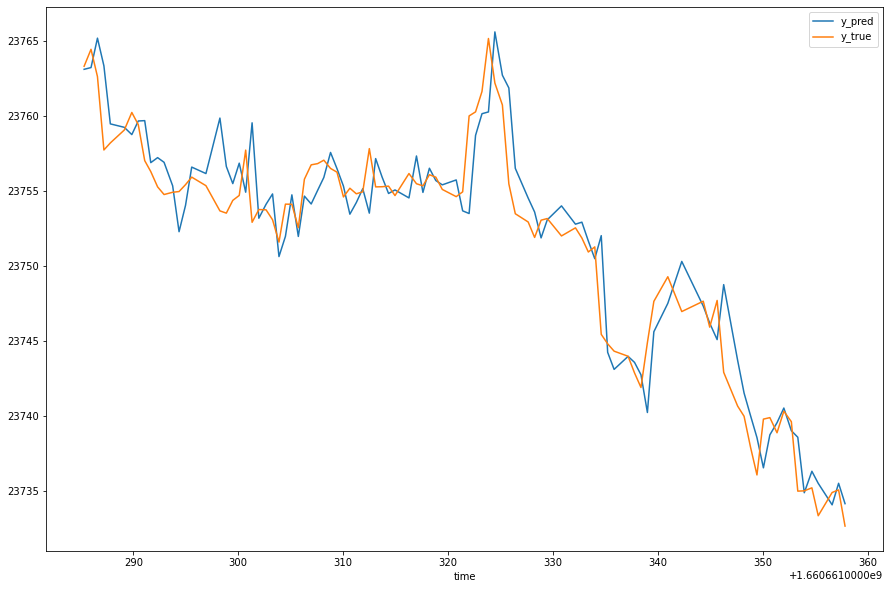

In [63]:
full_data_test["test_price_pred_13"].iloc[:100].plot(label="y_pred")
full_data_test["price_shift_13"].iloc[:100].plot(label="y_true")
plt.legend()

#### Save Prediction

In [55]:
# Train Data
path_train = "/Users/efim/PycharmProjects/SimpleAlgoTrade/model/data/"
full_data_train[["price","price_shift_13","train_price_pred_13"]].to_csv(path+"train_pred.csv")

# Test Data
path_test = "/Users/efim/PycharmProjects/SimpleAlgoTrade/model/data/"
full_data_test[["price","price_shift_13","test_price_pred_13"]].to_csv(path+"test_pred.csv")